In [ ]:
#| hide
#| eval: false
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [ ]:
#| default_exp losses
#| default_cls_lvl 3

In [ ]:
#| export
from __future__ import annotations
from fastai.imports import *
from fastai.torch_imports import *
from fastai.torch_core import *
from fastai.layers import *

In [ ]:
#| hide
from nbdev.showdoc import *

# Loss Functions
> Custom fastai loss functions

In [ ]:
#| export
class BaseLoss():
    "Same as `loss_cls`, but flattens input and target."
    activation=decodes=noops
    def __init__(self, 
        loss_cls, # Uninitialized PyTorch-compatible loss
        *args,
        axis:int=-1, # Class axis
        flatten:bool=True, # Flatten `inp` and `targ` before calculating loss
        floatify:bool=False, # Convert `targ` to `float`
        is_2d:bool=True, # Whether `flatten` keeps one or two channels when applied
        **kwargs
    ):
        store_attr("axis,flatten,floatify,is_2d")
        self.func = loss_cls(*args,**kwargs)
        self.func.__annotations__ = typing.get_type_hints(self.func, globalns=globals(), localns=locals()) # used to prevent unpicklable loss functions (https://github.com/fastai/fastai/issues/3901)
        functools.update_wrapper(self, self.func)

    def __repr__(self) -> str: return f"FlattenedLoss of {self.func}"
    
    @property
    def reduction(self) -> str: return self.func.reduction
    
    @reduction.setter
    def reduction(self, v:str):
        "Sets the reduction style (typically 'mean', 'sum', or 'none')" 
        self.func.reduction = v

    def _contiguous(self, x:Tensor) -> TensorBase:
        "Move `self.axis` to the last dimension and ensure tensor is contigous for `Tensor` otherwise just return"
        return TensorBase(x.transpose(self.axis,-1).contiguous()) if isinstance(x,torch.Tensor) else x

    def __call__(self, 
        inp:Tensor|MutableSequence, # Predictions from a `Learner`
        targ:Tensor|MutableSequence, # Actual y label
        **kwargs
    ) -> TensorBase: # `loss_cls` calculated on `inp` and `targ`
        inp,targ  = map(self._contiguous, (inp,targ))
        if self.floatify and targ.dtype!=torch.float16: targ = targ.float()
        if targ.dtype in [torch.int8, torch.int16, torch.int32]: targ = targ.long()
        if self.flatten: inp = inp.view(-1,inp.shape[-1]) if self.is_2d else inp.view(-1)
        return self.func.__call__(inp, targ.view(-1) if self.flatten else targ, **kwargs)
    
    def to(self, device:torch.device):
        "Move the loss function to a specified `device`"
        if isinstance(self.func, nn.Module): self.func.to(device)

Wrapping a general loss function inside of `BaseLoss` provides extra functionalities to your loss functions:

- flattens the tensors before trying to take the losses since it's more convenient (with a potential tranpose to put `axis` at the end)
- a potential `activation` method that tells the library if there is an activation fused in the loss (useful for inference and methods such as `Learner.get_preds` or `Learner.predict`)
- a potential <code>decodes</code> method that is used on predictions in inference (for instance, an argmax in classification)

The `args` and `kwargs` will be passed to `loss_cls` during the initialization to instantiate a loss function. `axis` is put at the end for losses like softmax that are often performed on the last axis. If `floatify=True`, the `targs` will be converted to floats (useful for losses that only accept float targets like `BCEWithLogitsLoss`), and `is_2d` determines if we flatten while keeping the first dimension (batch size) or completely flatten the input. We want the first for losses like Cross Entropy, and the second for pretty much anything else.

In [ ]:
#| export
@delegates()
class CrossEntropyLossFlat(BaseLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    y_int = True # y interpolation
    @use_kwargs_dict(keep=True, weight=None, ignore_index=-100, reduction='mean')
    def __init__(self, 
        *args, 
        axis:int=-1, # Class axis
        **kwargs
    ): 
        super().__init__(nn.CrossEntropyLoss, *args, axis=axis, **kwargs)
    
    def decodes(self, x:Tensor) -> Tensor:    
        "Converts model output to target format"
        return x.argmax(dim=self.axis)
    
    def activation(self, x:Tensor) -> Tensor: 
        "`nn.CrossEntropyLoss`'s fused activation function applied to model output"
        return F.softmax(x, dim=self.axis)

In [ ]:
tst = CrossEntropyLossFlat(reduction='none')
output = torch.randn(32, 5, 10)
target = torch.randint(0, 10, (32,5))
#nn.CrossEntropy would fail with those two tensors, but not our flattened version.
_ = tst(output, target)

test_fail(lambda x: nn.CrossEntropyLoss()(output,target))

#Associated activation is softmax
test_eq(tst.activation(output), F.softmax(output, dim=-1))
#This loss function has a decodes which is argmax
test_eq(tst.decodes(output), output.argmax(dim=-1))

In [ ]:
#In a segmentation task, we want to take the softmax over the channel dimension
tst = CrossEntropyLossFlat(axis=1)
output = torch.randn(32, 5, 128, 128)
target = torch.randint(0, 5, (32, 128, 128))
_ = tst(output, target)

test_eq(tst.activation(output), F.softmax(output, dim=1))
test_eq(tst.decodes(output), output.argmax(dim=1))

In [ ]:
#| hide
#| cuda
tst = CrossEntropyLossFlat(weight=torch.ones(10))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tst.to(device)
output = torch.randn(32, 10, device=device)
target = torch.randint(0, 10, (32,), device=device)
_ = tst(output, target)

[Focal Loss](https://arxiv.org/pdf/1708.02002.pdf) is the same as cross entropy except easy-to-classify observations are down-weighted in the loss calculation. The strength of down-weighting is proportional to the size of the `gamma` parameter. Put another way, the larger `gamma` the less the easy-to-classify observations contribute to the loss.

In [ ]:
#| export
class FocalLoss(Module):
    y_int=True # y interpolation
    def __init__(self, 
        gamma:float=2.0, # Focusing parameter. Higher values down-weight easy examples' contribution to loss
        weight:Tensor=None, # Manual rescaling weight given to each class
        reduction:str='mean' # PyTorch reduction to apply to the output
    ): 
        "Applies Focal Loss: https://arxiv.org/pdf/1708.02002.pdf"
        store_attr()
    
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        "Applies focal loss based on https://arxiv.org/pdf/1708.02002.pdf"
        ce_loss = F.cross_entropy(inp, targ, weight=self.weight, reduction="none")
        p_t = torch.exp(-ce_loss)
        loss = (1 - p_t)**self.gamma * ce_loss
        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()
        return loss


class FocalLossFlat(BaseLoss):
    """
    Same as CrossEntropyLossFlat but with focal paramter, `gamma`. Focal loss is introduced by Lin et al. 
    https://arxiv.org/pdf/1708.02002.pdf. Note the class weighting factor in the paper, alpha, can be 
    implemented through pytorch `weight` argument passed through to F.cross_entropy.
    """
    y_int = True # y interpolation
    @use_kwargs_dict(keep=True, weight=None, reduction='mean')
    def __init__(self, 
        *args, 
        gamma:float=2.0, # Focusing parameter. Higher values down-weight easy examples' contribution to loss
        axis:int=-1, # Class axis
        **kwargs
    ):
        super().__init__(FocalLoss, *args, gamma=gamma, axis=axis, **kwargs)
        
    def decodes(self, x:Tensor) -> Tensor: 
        "Converts model output to target format"
        return x.argmax(dim=self.axis)
    
    def activation(self, x:Tensor) -> Tensor: 
        "`F.cross_entropy`'s fused activation function applied to model output"
        return F.softmax(x, dim=self.axis)

In [ ]:
#Compare focal loss with gamma = 0 to cross entropy
fl = FocalLossFlat(gamma=0)
ce = CrossEntropyLossFlat()
output = torch.randn(32, 5, 10)
target = torch.randint(0, 10, (32,5))
test_close(fl(output, target), ce(output, target))
#Test focal loss with gamma > 0 is different than cross entropy
fl = FocalLossFlat(gamma=2)
test_ne(fl(output, target), ce(output, target))

In [ ]:
#In a segmentation task, we want to take the softmax over the channel dimension
fl = FocalLossFlat(gamma=0, axis=1)
ce = CrossEntropyLossFlat(axis=1)
output = torch.randn(32, 5, 128, 128)
target = torch.randint(0, 5, (32, 128, 128))
test_close(fl(output, target), ce(output, target), eps=1e-4)
test_eq(fl.activation(output), F.softmax(output, dim=1))
test_eq(fl.decodes(output), output.argmax(dim=1))

In [ ]:
#| export
@delegates()
class BCEWithLogitsLossFlat(BaseLoss):
    "Same as `nn.BCEWithLogitsLoss`, but flattens input and target."
    @use_kwargs_dict(keep=True, weight=None, reduction='mean', pos_weight=None)
    def __init__(self, 
        *args, 
        axis:int=-1, # Class axis
        floatify:bool=True, # Convert `targ` to `float`
        thresh:float=0.5, # The threshold on which to predict 
        **kwargs
    ):
        if kwargs.get('pos_weight', None) is not None and kwargs.get('flatten', None) is True:
            raise ValueError("`flatten` must be False when using `pos_weight` to avoid a RuntimeError due to shape mismatch")
        if kwargs.get('pos_weight', None) is not None: kwargs['flatten'] = False
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return x>self.thresh
    
    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

In [ ]:
tst = BCEWithLogitsLossFlat()
output = torch.randn(32, 5, 10)
target = torch.randn(32, 5, 10)
#nn.BCEWithLogitsLoss would fail with those two tensors, but not our flattened version.
_ = tst(output, target)
test_fail(lambda x: nn.BCEWithLogitsLoss()(output,target))
output = torch.randn(32, 5)
target = torch.randint(0,2,(32, 5))
#nn.BCEWithLogitsLoss would fail with int targets but not our flattened version.
_ = tst(output, target)
test_fail(lambda x: nn.BCEWithLogitsLoss()(output,target))

tst = BCEWithLogitsLossFlat(pos_weight=torch.ones(10))
output = torch.randn(32, 5, 10)
target = torch.randn(32, 5, 10)
_ = tst(output, target)
test_fail(lambda x: nn.BCEWithLogitsLoss()(output,target))

#Associated activation is sigmoid
test_eq(tst.activation(output), torch.sigmoid(output))

In [ ]:
#| export
@use_kwargs_dict(weight=None, reduction='mean')
def BCELossFlat(
    *args, 
    axis:int=-1, # Class axis
    floatify:bool=True, # Convert `targ` to `float`
    **kwargs
):
    "Same as `nn.BCELoss`, but flattens input and target."
    return BaseLoss(nn.BCELoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)

In [ ]:
tst = BCELossFlat()
output = torch.sigmoid(torch.randn(32, 5, 10))
target = torch.randint(0,2,(32, 5, 10))
_ = tst(output, target)
test_fail(lambda x: nn.BCELoss()(output,target))

In [ ]:
#| export
@use_kwargs_dict(reduction='mean')
def MSELossFlat(
    *args, 
    axis:int=-1, # Class axis
    floatify:bool=True, # Convert `targ` to `float`
    **kwargs
):
    "Same as `nn.MSELoss`, but flattens input and target."
    return BaseLoss(nn.MSELoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)

In [ ]:
tst = MSELossFlat()
output = torch.sigmoid(torch.randn(32, 5, 10))
target = torch.randint(0,2,(32, 5, 10))
_ = tst(output, target)
test_fail(lambda x: nn.MSELoss()(output,target))

In [ ]:
#| hide
#| cuda
#Test losses work in half precision
if torch.cuda.is_available():
    output = torch.sigmoid(torch.randn(32, 5, 10)).half().cuda()
    target = torch.randint(0,2,(32, 5, 10)).half().cuda()
    for tst in [BCELossFlat(), MSELossFlat()]: _ = tst(output, target)

In [ ]:
#| export
@use_kwargs_dict(reduction='mean')
def L1LossFlat(
    *args, 
    axis=-1, # Class axis
    floatify=True, # Convert `targ` to `float`
    **kwargs
):
    "Same as `nn.L1Loss`, but flattens input and target."
    return BaseLoss(nn.L1Loss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)

In [ ]:
#| export
class LabelSmoothingCrossEntropy(Module):
    y_int = True # y interpolation
    def __init__(self, 
        eps:float=0.1, # The weight for the interpolation formula
        weight:Tensor=None, # Manual rescaling weight given to each class passed to `F.nll_loss`
        reduction:str='mean' # PyTorch reduction to apply to the output
    ): 
        store_attr()

    def forward(self, output:Tensor, target:Tensor) -> Tensor:
        "Apply `F.log_softmax` on output then blend the loss/num_classes(`c`) with the `F.nll_loss`"
        c = output.size()[1]
        log_preds = F.log_softmax(output, dim=1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=1) #We divide by that size at the return line so sum and not mean
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target.long(), weight=self.weight, reduction=self.reduction)

    def activation(self, out:Tensor) -> Tensor: 
        "`F.log_softmax`'s fused activation function applied to model output"
        return F.softmax(out, dim=-1)
    
    def decodes(self, out:Tensor) -> Tensor:
        "Converts model output to target format"
        return out.argmax(dim=-1)

In [ ]:
lmce = LabelSmoothingCrossEntropy()
output = torch.randn(32, 5, 10)
target = torch.randint(0, 10, (32,5))
test_close(lmce(output.flatten(0,1), target.flatten()), lmce(output.transpose(-1,-2), target))

On top of the formula we define:

- a `reduction` attribute, that will be used when we call `Learner.get_preds`
- `weight` attribute to pass to BCE.
- an `activation` function that represents the activation fused in the loss (since we use cross entropy behind the scenes). It will be applied to the output of the model when calling `Learner.get_preds` or `Learner.predict`
- a <code>decodes</code> function that converts the output of the model to a format similar to the target (here indices). This is used in `Learner.predict` and `Learner.show_results` to decode the predictions 

In [ ]:
#| export
@delegates()
class LabelSmoothingCrossEntropyFlat(BaseLoss):
    "Same as `LabelSmoothingCrossEntropy`, but flattens input and target."
    y_int = True
    @use_kwargs_dict(keep=True, eps=0.1, reduction='mean')
    def __init__(self, 
        *args, 
        axis:int=-1, # Class axis
        **kwargs
    ): 
        super().__init__(LabelSmoothingCrossEntropy, *args, axis=axis, **kwargs)
    def activation(self, out:Tensor) -> Tensor: 
        "`LabelSmoothingCrossEntropy`'s fused activation function applied to model output"
        return F.softmax(out, dim=-1)
    
    def decodes(self, out:Tensor) -> Tensor:
        "Converts model output to target format"
        return out.argmax(dim=-1)

In [ ]:
#These two should always equal each other since the Flat version is just passing data through
lmce = LabelSmoothingCrossEntropy()
lmce_flat = LabelSmoothingCrossEntropyFlat()
output = torch.randn(32, 5, 10)
target = torch.randint(0, 10, (32,5))
test_close(lmce(output.transpose(-1,-2), target), lmce_flat(output,target))

We present a general `Dice` loss for segmentation tasks. It is commonly used together with `CrossEntropyLoss` or `FocalLoss` in kaggle competitions. This is very similar to the `DiceMulti` metric, but to be able to derivate through, we replace the `argmax` activation by a `softmax` and compare this with a one-hot encoded target mask. This function also adds a `smooth` parameter to help numerical stabilities in the intersection over union division. If your network has problem learning with this DiceLoss, try to set the `square_in_union` parameter in the DiceLoss constructor to `True`.

In [ ]:
#| export
class DiceLoss:
    "Dice loss for segmentation"
    def __init__(self, 
        axis:int=1, # Class axis
        smooth:float=1e-6, # Helps with numerical stabilities in the IoU division
        reduction:str="sum", # PyTorch reduction to apply to the output
        square_in_union:bool=False # Squares predictions to increase slope of gradients
    ):
        store_attr()
        
    def __call__(self, pred:Tensor, targ:Tensor) -> Tensor:
        "One-hot encodes targ, then runs IoU calculation then takes 1-dice value"
        targ = self._one_hot(targ, pred.shape[self.axis])
        pred, targ = TensorBase(pred), TensorBase(targ)
        assert pred.shape == targ.shape, 'input and target dimensions differ, DiceLoss expects non one-hot targs'
        pred = self.activation(pred)
        sum_dims = list(range(2, len(pred.shape)))
        inter = torch.sum(pred*targ, dim=sum_dims)        
        union = (torch.sum(pred**2+targ, dim=sum_dims) if self.square_in_union
            else torch.sum(pred+targ, dim=sum_dims))
        dice_score = (2. * inter + self.smooth)/(union + self.smooth)
        loss = 1- dice_score
        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()
        return loss
    @staticmethod
    def _one_hot(
        x:Tensor, # Non one-hot encoded targs
        classes:int, # The number of classes 
        axis:int=1 # The axis to stack for encoding (class dimension)
    ) -> Tensor:
        "Creates one binary mask per class"
        return torch.stack([torch.where(x==c, 1, 0) for c in range(classes)], axis=axis)
    
    def activation(self, x:Tensor) -> Tensor: 
        "Activation function applied to model output"
        return F.softmax(x, dim=self.axis)
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return x.argmax(dim=self.axis)

In [ ]:
dl = DiceLoss()
_x         = tensor( [[[1, 0, 2],
                       [2, 2, 1]]])
_one_hot_x = tensor([[[[0, 1, 0],
                       [0, 0, 0]],
                      [[1, 0, 0],
                       [0, 0, 1]],
                      [[0, 0, 1],
                       [1, 1, 0]]]])
test_eq(dl._one_hot(_x, 3), _one_hot_x)

In [ ]:
dl = DiceLoss()
model_output = tensor([[[[2., 1.],
                         [1., 5.]],
                        [[1,  2.],
                         [3., 1.]],
                        [[3., 0],
                         [4., 3.]]]])
target       =  tensor([[[2, 1],
                         [2, 0]]])
dl_out = dl(model_output, target)
test_eq(dl.decodes(model_output), target)

In [ ]:
dl = DiceLoss(reduction="mean")
#identical masks
model_output = tensor([[[.1], [.1], [100.]]])
target = tensor([[2]])
test_close(dl(model_output, target), 0)

#50% intersection
model_output = tensor([[[.1, 100.], [.1, .1], [100., .1]]])
target = tensor([[2, 1]])
test_close(dl(model_output, target), .66, eps=0.01)

As a test case for the dice loss consider satellite image segmentation. Let us say we have three classes: Background (0), River (1) and Road (2). Let us look at a specific target

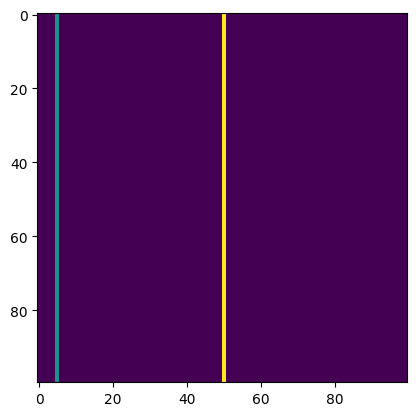

In [ ]:
target = torch.zeros(100,100)
target[:,5] = 1
target[:,50] = 2
plt.imshow(target);

Nearly everything is background in this example, and we have a thin river at the left of the image as well as a thin road in the middle of the image. If all our data looks similar to this, we say that there is a class imbalance, meaning that some classes (like river and road) appear relatively infrequently. If our model just predicted "background" (i.e. the value 0) for all pixels, it would be correct for most pixels. But this would be a bad model and the diceloss should reflect that

In [ ]:
model_output_all_background = torch.zeros(3, 100,100)
# assign probability 1 to class 0 everywhere
# to get probability 1, we just need a high model output before softmax gets applied
model_output_all_background[0,:,:] = 100

In [ ]:
# add a batch dimension
model_output_all_background = torch.unsqueeze(model_output_all_background,0)
target = torch.unsqueeze(target,0)

Our dice score should be around 1/3 here, because the "background" class is predicted correctly (and that for nearly every pixel), but the other two clases are never predicted correctly. Dice score of 1/3 means dice loss of 1 - 1/3 = 2/3:

In [ ]:
test_close(dl(model_output_all_background, target), 0.67, eps=0.01)

If the model would predict everything correctly, the dice loss should be zero:

In [ ]:
correct_model_output = torch.zeros(3, 100,100)
correct_model_output[0,:,:] = 100
correct_model_output[0,:,5] = 0
correct_model_output[0,:,50] = 0
correct_model_output[1,:,5] = 100
correct_model_output[2,:,50] = 100
correct_model_output = torch.unsqueeze(correct_model_output, 0)

In [ ]:
test_close(dl(correct_model_output, target), 0)

In [ ]:
#| hide
#| cuda
#Test DicceLoss work in half precision
if torch.cuda.is_available():
    output = torch.randn(32, 4, 5, 10).half().cuda()
    target = torch.randint(0,2,(32, 5, 10)).half().cuda()
    _ = dl(output, target)

You could easily combine this loss with `FocalLoss` defining a `CombinedLoss`, to balance between global (Dice) and local (Focal) features on the target mask.

In [ ]:
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1., alpha=1.):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth)
        
    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [ ]:
cl = CombinedLoss()
output = torch.randn(32, 4, 5, 10)
target = torch.randint(0,2,(32, 5, 10))
_ = cl(output, target)

In [ ]:
# Tests to catch future changes to pickle which cause some loss functions to be 'unpicklable'.
# This causes problems with `Learner.export` as the model can't be pickled with these particular loss funcitons.

losses_picklable = [
 (BCELossFlat(), True),
 (BCEWithLogitsLossFlat(), True),
 (CombinedLoss(), True),
 (CrossEntropyLossFlat(), True),
 (DiceLoss(), True),
 (FocalLoss(), True),
 (FocalLossFlat(), True),
 (L1LossFlat(), True),
 (LabelSmoothingCrossEntropyFlat(), True),
 (LabelSmoothingCrossEntropy(), True),
 (MSELossFlat(), True),
]

for loss, picklable in losses_picklable:
    try:
        pickle.dumps(loss, protocol=2)
    except (pickle.PicklingError, TypeError) as e:
        if picklable:
            # Loss was previously picklable but isn't currently
            raise e

## Export -

In [ ]:
#| hide
from nbdev import *
nbdev_export()